In [2]:
# Random Forest
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset
dataset = pd.read_csv('/content/ConsideredMeanSTDP2Authors.csv')

# Features & target variables
X = dataset.iloc[:, 1:19].values
y = dataset.iloc[:, 20].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Hyperparameters
rf_parameters = {'max_depth': range(1, 5), 'n_estimators': [20, 50, 100]}

# Strategy
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize metrics
rf_accuracy_scores = []
rf_precision_scores = []
rf_recall_scores = []
rf_f1_scores = []

# Confusion matrix
overall_conf_matrix = np.zeros((2, 2), dtype=int)

# Store the best model
best_rf_model = None
best_rf_score = 0.0

# Perform cross-validation
for train_index, test_index in outer_cv.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    rf_classifier = RandomForestClassifier(random_state=42)
    rf_grid_search = GridSearchCV(rf_classifier, rf_parameters, cv=inner_cv)
    rf_grid_search.fit(X_train_fold, y_train_fold)
    rf_best_params = rf_grid_search.best_params_
    rf_best_model = RandomForestClassifier(random_state=42, **rf_best_params)

    # Fit best model
    rf_best_model.fit(X_train_fold, y_train_fold)

    # Evaluation on test set
    rf_predictions = rf_best_model.predict(X_test_fold)
    current_score = accuracy_score(y_test_fold, rf_predictions)

    # Store best model
    if current_score > best_rf_score:
        best_rf_score = current_score
        best_rf_model = rf_best_model

    # Test set
    rf_accuracy_scores.append(accuracy_score(y_test_fold, rf_predictions))
    rf_precision_scores.append(precision_score(y_test_fold, rf_predictions))
    rf_recall_scores.append(recall_score(y_test_fold, rf_predictions))
    rf_f1_scores.append(f1_score(y_test_fold, rf_predictions))

    # Update overall CM with the fold's results
    fold_conf_matrix = confusion_matrix(y_test_fold, rf_predictions)
    overall_conf_matrix += fold_conf_matrix

# Save the best model
if best_rf_model is not None:
    joblib.dump(best_rf_model, 'best_random_forest_model.pkl')

# Test set metrics
rf_average_accuracy_test = np.mean(rf_accuracy_scores)
rf_average_precision_test = np.mean(rf_precision_scores)
rf_average_recall_test = np.mean(rf_recall_scores)
rf_average_f1_test = np.mean(rf_f1_scores)

# Print
print("\nRandom Forest Test Set:")
print("Accuracy:", round(rf_average_accuracy_test, 4))
print("Precision:", round(rf_average_precision_test, 4))
print("Recall:", round(rf_average_recall_test, 4))
print("F1-score:", round(rf_average_f1_test, 4))



Random Forest Test Set:
Accuracy: 0.9688
Precision: 0.9522
Recall: 0.9875
F1-score: 0.9694



Overall Confusion Matrix:
[[152   8]
 [  2 158]]


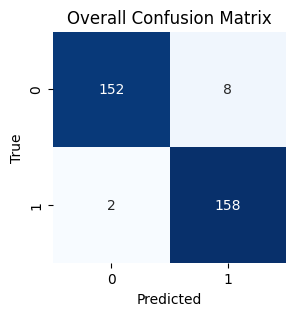

In [3]:
# Print and plot
print("\nOverall Confusion Matrix:")
print(overall_conf_matrix)

plt.figure(figsize=(3, 3))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()